In [151]:
# common imports
import zipfile, os, time, datetime, math, missingno, re
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from collections import Counter
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sc_remover(text):
    return re.sub('[^A-Za-z0-9/.()]+', '', text)

In [3]:
filedir = "./Datasets"
filenm = ["sample_BiddingData_Bundang_1901"]

for jj in filenm:
    data = zipfile.ZipFile(os.path.join(filedir, jj)+".zip")
    data.extract(jj+".xlsx", filedir)
    data.close()

In [4]:
df = pd.read_excel(os.path.join(filedir, filenm[0])+".xlsx", index_col="No.", dtype='str')
df = df.reset_index(drop=True)

In [5]:
df.head(2).T

0                        1
거점                                               분당                       분당
판매일                                      2019-02-19               2019-02-19
모델명                         ALL_NEW_K7 2.2 디젤 프레스티지  ALL_NEW_K7 2.4 GDI 리미티드
최초등록일                                    2017-01-25               2017-02-06
년식                                             2017                     2017
미션                                              A/T                      A/T
연료                                               디젤                      가솔린
색상                                       ABP)오로라블랙펄               ABP)오로라블랙펄
배기량                                            2199                     2359
주행거리                                          69208                    32827
용도                                               렌트                       자가
소유                                             법인상품                     법인상품
평가\n등급                                            A                        A
평가\n점수                                            6                        8
매입처                                             nan                      nan
수출\n항목                                            X                        X
신차가격                                            nan                      nan
매입금액                                            nan                      nan
희망가격                                            nan                      nan
낙찰가격                                       20500000                 26400000
옵션                          ABS,AB2,VDC,스마트키,내비(일반)  ABS,AB2,VDC,스마트키,내비(일반)
특기사항    필러트림/헤드라이닝/스탭몰딩불량, 엔진오일누유, 엔진/PS/터보이음, 실내오염        스텝몰딩불량, 엔진오일누유/이음
상품번호                                      1902A0525                1902A0456

In [6]:
df.describe(include='all')

거점         판매일                    모델명       최초등록일    년식   미션   연료  \
count   418         418                    418         418   418  418  418   
unique    1           1                    274         343    19    2    5   
top      분당  2019-02-19  엑센트(RB) 1.4 VVT Smart  2015-01-29  2016  A/T  가솔린   
freq    418         418                     10           6   106  393  196   

         색상   배기량   주행거리    ...     평가\n점수  매입처 수출\n항목 신차가격 매입금액 희망가격  \
count   418   418    418    ...        418  418    418  418  418  418   
unique  107    54    418    ...          9    1      2    1    1    1   
top      기타  1995  86445    ...          1  nan      X  nan  nan  nan   
freq     53    47      1    ...         84  418    358  418  418  418   

           낙찰가격                       옵션 특기사항       상품번호  
count       418                      418  418        418  
unique      324                       64  403        418  
top     5900000  ABS,AB2,VDC,스마트키,내비(일반)    /  1902A0569  
freq          4                       85   14          1  

[4 rows x 23 columns]

In [7]:
df.dtypes

거점        object
판매일       object
모델명       object
최초등록일     object
년식        object
미션        object
연료        object
색상        object
배기량       object
주행거리      object
용도        object
소유        object
평가\n등급    object
평가\n점수    object
매입처       object
수출\n항목    object
신차가격      object
매입금액      object
희망가격      object
낙찰가격      object
옵션        object
특기사항      object
상품번호      object
dtype: object

In [132]:
# [re.sub('\n','',i) for i in df.columns]

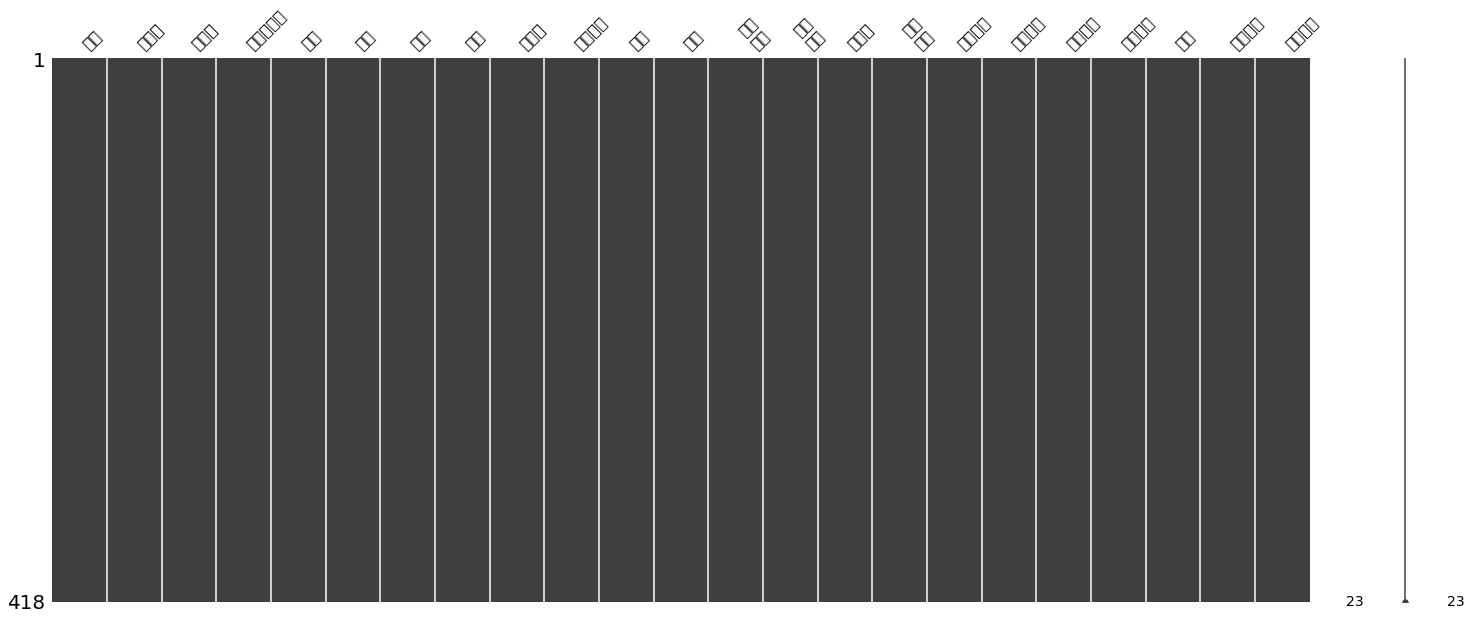

In [8]:
missingno.matrix(df)

In [9]:
# 고유값이 1개인 컬럼 제거
df = df.drop([column for column in df.columns if len(df[column].unique())==1], axis = 1)

In [31]:
df.head(2)

모델명       최초등록일    년식   미션   연료          색상   배기량  \
0  ALL_NEW_K7 2.2 디젤 프레스티지  2017-01-25  2017  A/T   디젤  ABP)오로라블랙펄  2199   
1  ALL_NEW_K7 2.4 GDI 리미티드  2017-02-06  2017  A/T  가솔린  ABP)오로라블랙펄  2359   

    주행거리  용도    소유 평가\n등급 평가\n점수 수출\n항목      낙찰가격                       옵션  \
0  69208  렌트  법인상품      A      6      X  20500000  ABS,AB2,VDC,스마트키,내비(일반)   
1  32827  자가  법인상품      A      8      X  26400000  ABS,AB2,VDC,스마트키,내비(일반)   

                                          특기사항       상품번호  
0  필러트림/헤드라이닝/스탭몰딩불량, 엔진오일누유, 엔진/PS/터보이음, 실내오염  1902A0525  
1                            스텝몰딩불량, 엔진오일누유/이음  1902A0456

## 변수 하나하나 살펴보기

In [ ]:
# 0. 
# 딜러는 어떤 특징을 가지고 있을까?
# 주로 취급하는 차종/회사/기타기준 있을까?
# 어떤걸 보고 구매를 할까? 선택의 기준이 무엇일까?
# 가격예측은.... 예상 낙찰가를 예상하는 것일 가능성이 크다.(혹은 최소 금액 ~ 최대금액 바운더리?)
# 추천에는 딜러의 구매 이력도 봐야겟지만. 딜러가 구매하는것도 한계가 있으니 딜러의 버짓도 추정하면 좋겟다.
# 한개의 차를 여러 딜러에게 모두 추천하면 경쟁률이 너무 높아질 수 있겟다.... 고려할 필요는 없지 않나?
# 핫딜, 최신 등록차, 비딩 관심차, 리마켓팅으로 추정된 차량. 고스펙 차량, 추천 차량. 신차가격대비 고할인율 차량....조회!
# FDS 예제1 : https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services
# FDS 예제2 : https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

In [11]:
# 1. 모델명
# df.모델명.str.split(' ')
df.모델명.unique()[:10]
# 특별한 규칙이 없다. 마스터 테이블 정보를 확보해서 맵핑하거나, NLP로 처리해야 할듯.

array(['ALL_NEW_K7 2.2 디젤 프레스티지', 'ALL_NEW_K7 2.4 GDI 리미티드',
       'ALL_NEW_K7 2.4 GDI 프레스티지', 'ALL_NEW_K7 3.3 GDI 노블레스',
       'ALL_NEW_K7 3.3 GDI 노블레스 스페셜', 'ALL_NEW_크루즈 1.4 터보 LTZ',
       'Amazing_NEW_크루즈 1.8 가솔린 LT', 'BMW X4 XDrive 20d',
       'EQ900 3.3T-GDI PRESTIGE', 'EQ900 3.8GDI LUXURY'], dtype=object)

In [143]:
df.모델명.unique()

array(['ALL_NEW_K7 2.2 디젤 프레스티지', 'ALL_NEW_K7 2.4 GDI 리미티드',
       'ALL_NEW_K7 2.4 GDI 프레스티지', 'ALL_NEW_K7 3.3 GDI 노블레스',
       'ALL_NEW_K7 3.3 GDI 노블레스 스페셜', 'ALL_NEW_크루즈 1.4 터보 LTZ',
       'Amazing_NEW_크루즈 1.8 가솔린 LT', 'BMW X4 XDrive 20d',
       'EQ900 3.3T-GDI PRESTIGE', 'EQ900 3.8GDI LUXURY',
       'EQ900 5.0GDI PRESTIGE', 'G70 3.3가솔린T스포츠 슈프림 H-TRAC',
       'G80 3.3 Luxury', 'G80 3.3 Premium Luxury',
       'G80 3.3T SPORT H-TRAC', 'JEEP 그랜드체로키', 'K3 1.6 가솔린(4도어) Deluxe',
       'K3 1.6 가솔린(4도어) Luxury', 'K3 1.6 디젤 Prestige',
       'K5 2.0LPI 렌터카 디럭스', 'K5 2.0LPI 렌터카 스마트', 'K5 2.0가솔린 럭셔리',
       'K5 2.0가솔린 프레스티지', 'K5 2.0하이브리드 Prestige',
       'K7 (The prestige)3.0GDI 프레스티지', 'K7 (The prestige)3.0LPI렌트 프레스티지',
       'K7 VG270 LPI 렌트 프레스티지', 'K9 3.3 GDI 이그제큐티브',
       'New투싼 ix 2.0 디젤(2WD) Smart Special', 'New투싼 ix 2.0 디젤(4WD) Smart',
       'Next_Innovation_K5 가솔린 2.0 MX 프레스티지',
       'Next_Innovation_K5 디젤 1.7 MX 디럭스', 'QM3 1.5 LE', 'QM3 1.5 SE',
       'QM3 1.5 디젤 LE'

dtype('O')

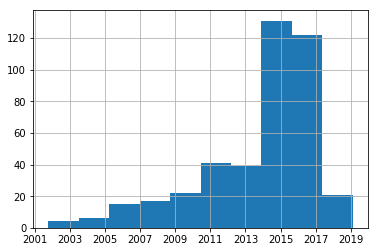

In [12]:
# 2. 최초등록일
display(df.최초등록일.dtype)
pd.to_datetime(df.최초등록일).hist()
# datetime형태로 변경해야함. 2001년 등록했는데 거즘 10년간 안팔린 매물도 극소량 있음. 2014년 매입 물량도 5년이 지난 시점에서 여전히 있음.
# 최초등록일이 과거일수록 저렴한 차일 가능성 있다. 
# 분포는 필연적으로 최근 날짜(우측)으로 치우쳐 있다.

dtype('O')

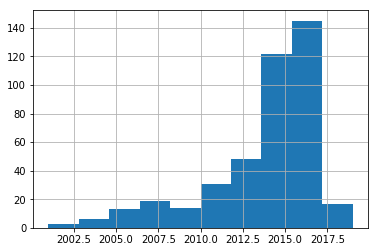

In [13]:
# 3. 연식
display(df.년식.dtype)
df.년식.astype(int).hist()
# 최초등록일과 매우 유사한 형태의 분포를 보임.
# 연식 특성상 최초 등록일보다 같거나 이전연도
# 분포는 필연적으로 최근 날짜(우측)으로 치우쳐 있다.

In [20]:
# 4. 미션
display(df.미션.dtype)
df.미션.value_counts()
# 오토가 95%정도 차지

dtype('O')

A/T    393
M/T     25
Name: 미션, dtype: int64

In [21]:
# 5. 연료
display(df.연료.dtype)
df.연료.value_counts()
# 가솔린, 디젤이 대부분 차지.

dtype('O')

가솔린       196
디젤        166
LPG        42
Hybrid     10
겸용          4
Name: 연료, dtype: int64

In [24]:
# 6. 색상
display(df.색상.dtype)
df.색상.value_counts()[:10]
# 기타색상이 많음. 차종과 연계해서 리뷰 필요.
# 구매여부에 영향을끼치는 변수인지도 확인 필요.
# 특정 색생이 대부분을 차지, 블랙/화이트/실버류

dtype('O')

기타             53
ABP)오로라블랙펄     27
TB7)팬텀블랙       24
SWP)스노우화이트펄    22
흰              20
UD)순백          14
YB6)오닉스블랙      14
3D)은빛실버        12
PGU)크리스탈화이트    11
P2S)하이퍼메탈릭     10
Name: 색상, dtype: int64

dtype('O')

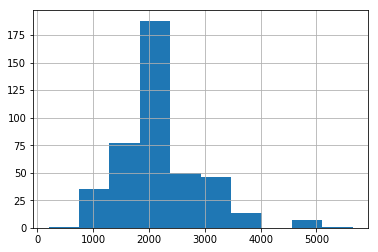

In [26]:
# 7. 배기량
display(df.배기량.dtype)
df.배기량.astype(int).hist()
# 정규분포띔. 2000이 중심.
# 차종과 연관있음.

dtype('O')

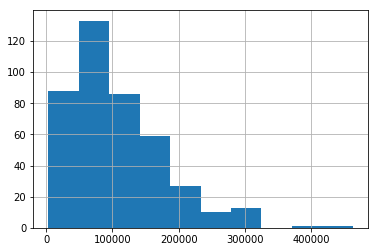

In [28]:
# 8. 주행거리
display(df.주행거리.dtype)
df.주행거리.astype(int).hist()
# int형태 또는 비닝 변환필요.
# 분포는 짧은거리쪽(좌측)으로 치우쳐 있다.

In [29]:
# 7. 용도
display(df.용도.dtype)
df.용도.value_counts()[:10]

dtype('O')

자가     196
렌트     155
리스      29
업무      29
nan      9
Name: 용도, dtype: int64

In [30]:
# 8. 소유
display(df.소유.dtype)
df.소유.value_counts()[:10]
# 소유/용도 크로스 체크 필요.

dtype('O')

법인상품    320
개인       53
법인       34
상품용      11
Name: 소유, dtype: int64

In [39]:
# 9. 평가등급
display(df['평가\n등급'].dtype)
df['평가\n등급'].value_counts()[:10]

dtype('O')

A    368
B     23
C     14
F      9
D      4
Name: 평가\n등급, dtype: int64

dtype('O')

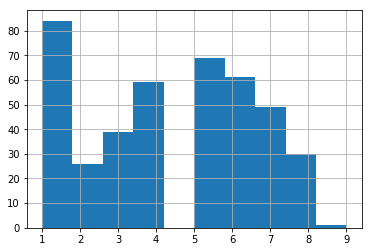

In [41]:
# 10. 평가점수
display(df['평가\n점수'].dtype)
df['평가\n점수'].astype(int).hist()
# 평가 등급/점수 크로스 체크 필요. 

In [44]:
# 11. 수출항목
display(df['수출\n항목'].dtype)
df['수출\n항목'].value_counts()[:10]
# 내수용이 압도적

dtype('O')

X    358
O     60
Name: 수출\n항목, dtype: int64

dtype('O')

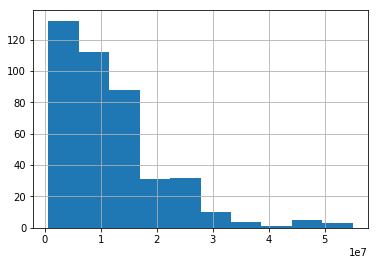

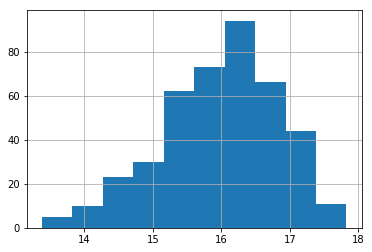

In [72]:
# 12. 낙찰가격
display(df.낙찰가격.dtype)
display(df.낙찰가격.astype(int).hist())
plt.show()
display(np.log(df.낙찰가격.astype(int)).hist())
plt.show()
# 2천만원 미만가격에 몰려있는 좌로 치우친 분포
# Y값이다. 로그변환을 할 필요가 있다.
# 최소값이 100만원.... 너무 극단적인 케이스는 제외 필요할듯.

Counter({'ABS': 386,
         'AB2': 354,
         'VDC': 279,
         '스마트키': 249,
         '내비(일반)': 179,
         'TCS': 26,
         '썬루프(일반)': 50,
         'DIS': 22,
         '내비게이션': 14,
         '썬루프': 6,
         '썬루프(파노라마)': 31,
         'AB1': 25,
         'ESP': 10,
         'nan': 18})

In [153]:
# 13. 옵션
tmp = df.옵션.str.split(',')
display(tmp[:10])
Counter(list(chain.from_iterable(tmp)))
# 옵션 리스트. 멀티핫으로 표현해야 함. 단 시퀀스로서의 특징은 없음.

0             [ABS, AB2, VDC, 스마트키, 내비(일반)]
1             [ABS, AB2, VDC, 스마트키, 내비(일반)]
2             [ABS, AB2, VDC, 스마트키, 내비(일반)]
3             [ABS, AB2, VDC, 스마트키, 내비(일반)]
4             [ABS, AB2, VDC, 스마트키, 내비(일반)]
5    [ABS, AB2, TCS, 스마트키, 내비(일반), 썬루프(일반)]
6                           [ABS, AB2, TCS]
7    [ABS, AB2, TCS, 스마트키, 내비(일반), 썬루프(일반)]
8             [ABS, AB2, VDC, 스마트키, 내비(일반)]
9        [ABS, AB2, DIS, VDC, 스마트키, 내비(일반)]
Name: 옵션, dtype: object

Counter({'ABS': 386,
         'AB2': 354,
         'VDC': 279,
         '스마트키': 249,
         '내비(일반)': 179,
         'TCS': 26,
         '썬루프(일반)': 50,
         'DIS': 22,
         '내비게이션': 14,
         '썬루프': 6,
         '썬루프(파노라마)': 31,
         'AB1': 25,
         'ESP': 10,
         'nan': 18})

In [154]:
# [re.sub('\n','',i) for i in df.columns]
tmp2 = df.특기사항.str.replace('\n','')
tmp2 = tmp2.str.replace('*','')
tmp2 = tmp2.str.split(',')
display(tmp2[:10])
Counter(list(chain.from_iterable(tmp2)))
# 점검 내용. NLP처리가 필요할듯.

0     [필러트림/헤드라이닝/스탭몰딩불량,  엔진오일누유,  엔진/PS/터보이음,  실내오염]
1                                 [스텝몰딩불량,  엔진오일누유/이음]
2    [시트/필러트림/스텝몰딩불량,  엔진오일누유/이음,  ps이음,  리어펜더(우)판금...
3    [PS/헤드라이닝불량,  엔진오일누유,  PS이음심함/유격,  엔진룸/실내오염,  ...
4                                       [엔진/TPMS경고등점등]
5                                            [헤드라이닝불량]
6                                            [엔진/PS이음]
7    [실차확인필/클레임불가,  PS불량,  엔진/미션오일누유,  엔진/터보/하체이음, ...
8          [레이더센서/전동미러불량,  엔진/미션오일누유,  엔진/PS이음,  엔진부조]
9                              [시트/스텝몰딩불량,  엔진오일누유/이음]
Name: 특기사항, dtype: object

Counter({'필러트림/헤드라이닝/스탭몰딩불량': 1,
         ' 엔진오일누유': 16,
         ' 엔진/PS/터보이음': 3,
         ' 실내오염': 31,
         '스텝몰딩불량': 4,
         ' 엔진오일누유/이음': 47,
         '시트/필러트림/스텝몰딩불량': 1,
         ' ps이음': 2,
         ' 리어펜더(우)판금/용접': 138,
         'PS/헤드라이닝불량': 3,
         ' PS이음심함/유격': 2,
         ' 엔진룸/실내오염': 3,
         ' 뒷번호판볼트장착불가확인요': 1,
         '': 24,
         '엔진/TPMS경고등점등': 1,
         '헤드라이닝불량': 5,
         '엔진/PS이음': 1,
         '실차확인필/클레임불가': 16,
         ' PS불량': 3,
         ' 엔진/미션오일누유': 114,
         ' 엔진/터보/하체이음': 10,
         ' 하체부식': 51,
         ' 앞펜더(좌)교환': 90,
         ' 리어펜더(좌)판금/용접': 111,
         ' 인사이드패널(좌)판금/용접': 43,
         '레이더센서/전동미러불량': 1,
         ' 엔진/PS이음': 14,
         ' 엔진부조': 69,
         '시트/스텝몰딩불량': 5,
         '파워도어불량': 1,
         ' 엔진오일누유/이음심함': 9,
         ' PS/하체/터보이음': 4,
         ' PS유격': 100,
         ' 제동이음': 7,
         '시트불량': 15,
         '후석리모컨/내장재불량': 1,
         ' 엔진오일누유심함/이음': 24,
         ' PS이음': 12,
         ' 변속충격': 171,
      

In [126]:
# 15. 상품번호
df.상품번호.unique()[:10] 
# 고유값 pk

array(['1902A0525', '1902A0456', '1902A0539', '1901A1925', '1902A0328',
       '1902A0468', '1901A2146', '1902A0463', '1901A1614', '1902A0621'],
      dtype=object)

# -----------------------------------
#### https://github.com/sa757/Wide-and-Deep-PyTorch
#### https://wingnim.tistory.com/32

In [158]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


use_cuda = torch.cuda.is_available()


class MultipleOptimizer(object):
    """Helper to use multiple optimizers as one.
    Parameters:
    ----------
    opts: List
        List with the names of the optimizers to use
    """
    def __init__(self, opts):
        self.optimizers = opts

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()


class WideDeepLoader(Dataset):
    """Helper to facilitate loading the data to the pytorch models.
    Parameters:
    ----------
    data: namedtuple with 3 elements - (wide_input_data, deep_inp_data, target)
    """
    def __init__(self, data):

        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)


class WideDeep(nn.Module):
    """ Wide and Deep model. As explained in Heng-Tze Cheng et al., 2016, the
    model taked the wide features and the deep features after being passed through
    the hidden layers and connects them to an output neuron. For details, please
    refer to the paper and the corresponding tutorial in the tensorflow site:
    https://www.tensorflow.org/tutorials/wide_and_deep
    Parameters:
    --------
    wide_dim: Int
        dim of the wide-side input tensor
    embeddings_input: Tuple.
        3-elements tuple with the embeddings "set-up" - (col_name,
        unique_values, embeddings dim)
    continuous_cols: List.
        list with the name of the continuum columns
    deep_column_idx: Dict
        dictionary where the keys are column names and the values their
        corresponding index in the deep-side input tensor
    hidden_layers: List
        list with the number of units per hidden layer
    encoding_dict: Dict
        dictionary with the label-encode mapping
    n_class: Int
        number of classes. Defaults to 1 if logistic or regression
    dropout: Float
    """

    def __init__(self,
                 wide_dim,
                 embeddings_input,
                 continuous_cols,
                 deep_column_idx,
                 hidden_layers,
                 dropout,
                 encoding_dict,
                 n_class):

        super(WideDeep, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.encoding_dict = encoding_dict
        self.n_class = n_class

        # Build the embedding layers to be passed through the deep-side
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        # Build the deep-side hidden layers with dropout if specified
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        if self.dropout:
            self.linear_1_drop = nn.Dropout(self.dropout[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))
            if self.dropout:
                setattr(self, 'linear_'+str(i+1)+'_drop', nn.Dropout(self.dropout[i]))

        # Connect the wide- and dee-side of the model to the output neuron(s)
        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, self.n_class)


    @staticmethod
    def set_optimizer(model_params, optimizer, learning_rate, momentum=0.0):
        """
        Simple helper so we can set the optimizers with a string, which will
        be convenient later. Add more parameters if you need.
        """
        if optimizer == "Adam":
            return torch.optim.Adam(model_params, lr=learning_rate)
        if optimizer == "Adagrad":
            return torch.optim.Adam(model_params, lr=learning_rate)
        if optimizer == "RMSprop":
            return torch.optim.RMSprop(model_params, lr=learning_rate, momentum=momentum)
        if optimizer == "SGD":
            return torch.optim.SGD(model_params, lr=learning_rate, momentum=momentum)


    @staticmethod
    def set_method(method):
        """
        Simple helper so we can set the method with a string, which will
        be convenient later.
        """
        if method =='regression':
            return None, F.mse_loss
        if method =='logistic':
            return torch.sigmoid, F.binary_cross_entropy
        if method=='multiclass':
            return F.softmax, F.cross_entropy


    def compile(self, method="logistic", optimizer="Adam", learning_rate=0.001, momentum=0.0):
        """Wrapper to set the activation, loss and the optimizer.
        Parameters:
        ----------
        method: String
            'regression', 'logistic' or 'multiclass'
        optimizer: String or Dict
            if string one of the following: 'SGD', 'Adam', or 'RMSprop'
            if Dictionary must contain two elements for the wide and deep
            parts respectively with keys 'wide' and 'deep'. E.g.
            optimizer = {'wide: ['SGD', 0.001, 0.3]', 'deep':['Adam', 0.001]}
        """
        self.method = method
        self.activation, self.criterion = self.set_method(method)

        if type(optimizer) is dict:
            params = list(self.parameters())
            # last two sets of parameters are the weights and bias of the last
            # linear layer
            last_linear_weights = params[-2]
            # by construction, the weights from wide_dim "in advance"
            # correspond to the wide side and will use one optimizer
            wide_params = [nn.Parameter(last_linear_weights[:, -self.wide_dim:])]
            # The weights from the deep side and the bias will use the other
            # optimizer
            deep_weights = last_linear_weights[:, :-self.wide_dim]
            deep_params = params[:-2] + [nn.Parameter(deep_weights)] + [params[-1]]
            # Very inelegant, but will do for now
            if len(optimizer['wide'])>2:
                wide_opt = self.set_optimizer(wide_params, optimizer['wide'][0], optimizer['wide'][1], optimizer['wide'][2])
            else:
                wide_opt = self.set_optimizer(wide_params, optimizer['wide'][0], optimizer['wide'][1])
            if len(optimizer['deep'])>2:
                deep_opt = self.set_optimizer(deep_params, optimizer['deep'][0], optimizer['deep'][1], optimizer['deep'][2])
            else:
                deep_opt = self.set_optimizer(deep_params, optimizer['deep'][0], optimizer['deep'][1])
            self.optimizer = MultipleOptimizer([wide_opt, deep_opt])
        elif type(optimizer) is str:
            self.optimizer = self.set_optimizer(self.parameters(), optimizer, learning_rate, momentum)


    def forward(self, X_w, X_d):
        """Implementation of the forward pass.
        Parameters:
        ----------
        X_w (torch.tensor) : wide-side input tensor
        X_d (torch.tensor) : deep-side input tensor
        Returns:
        --------
        out (torch.tensor) : result of the output neuron(s)
        """
        # Deep Side
        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X_d[:, cont_idx].float()]
            deep_inp = torch.cat(emb+cont, 1)
        else:
            deep_inp = torch.cat(emb, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        if self.dropout:
            x_deep = self.linear_1_drop(x_deep)
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )
            if self.dropout:
                x_deep = getattr(self, 'linear_'+str(i+1)+'_drop')(x_deep)

        # Deep + Wide sides
        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)
        if not self.activation:
            out = self.output(wide_deep_input)
        else:
            if (self.activation==F.softmax):
                out = self.activation(self.output(wide_deep_input), dim=1)
            else:
                out = self.activation(self.output(wide_deep_input))

        return out


    def fit(self, dataset, n_epochs, batch_size):
        """Run the model for the training set at dataset.
        Parameters:
        ----------
        dataset (dict): dictionary with the training sets -
        X_wide_train, X_deep_train, target
        n_epochs (int)
        batch_size (int)
        """
        widedeep_dataset = WideDeepLoader(dataset)
        train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        # set the model in training mode
        net = self.train()
        for epoch in range(n_epochs):
            total=0
            correct=0
            for i, (X_wide, X_deep, target) in enumerate(train_loader):
                X_w = Variable(X_wide)
                X_d = Variable(X_deep)
                y = (Variable(target).float() if self.method != 'multiclass' else Variable(target))

                if use_cuda:
                    X_w, X_d, y = X_w.cuda(), X_d.cuda(), y.cuda()

                self.optimizer.zero_grad()
                y_pred =  net(X_w, X_d)
                if(self.criterion == F.cross_entropy):
                    loss = self.criterion(y_pred, y) #[batch_size, 1]
                else:
                    loss = self.criterion(y_pred, y.view(-1, 1)) #[batch_size, 1]
                loss.backward()
                self.optimizer.step()

                if self.method != "regression":
                    total+= y.size(0)
                    if self.method == 'logistic':
                        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                    if self.method == "multiclass":
                        _, y_pred_cat = torch.max(y_pred, 1)
                    correct+= float((y_pred_cat == y).sum().item())

            if self.method != "regression":
                print ('Epoch {} of {}, Loss: {}, accuracy: {}'.format(epoch+1,
                    n_epochs, round(loss.item(),3), round(correct/total,4)))
            else:
                print ('Epoch {} of {}, Loss: {}'.format(epoch+1, n_epochs,
                    round(loss.item(),3)))


    def predict(self, dataset):
        """Predict target for dataset.
        Parameters:
        ----------
        dataset (dict): dictionary with the testing dataset -
        X_wide_test, X_deep_test, target
        Returns:
        --------
        array-like with the target for dataset
        """

        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "regression":
            return pred.squeeze(1).data.numpy()
        if self.method == "logistic":
            return (pred > 0.5).squeeze(1).data.numpy()
        if self.method == "multiclass":
            _, pred_cat = torch.max(pred, 1)
            return pred_cat.data.numpy()


    def predict_proba(self, dataset):
        """Predict predict probability for dataset.
        This method will only work with method logistic/multiclass
        Parameters:
        ----------
        dataset (dict): dictionary with the testing dataset -
        X_wide_test, X_deep_test, target
        Returns:
        --------
        array-like with the probability for dataset.
        """

        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "logistic":
            pred = pred.squeeze(1).data.numpy()
            probs = np.zeros([pred.shape[0],2])
            probs[:,0] = 1-pred
            probs[:,1] = pred
            return probs
        if self.method == "multiclass":
            return pred.data.numpy()


    def get_embeddings(self, col_name):
        """Extract the embeddings for the embedding columns.
        Parameters:
        -----------
        col_name (str) : column we want the embedding for
        Returns:
        --------
        embeddings_dict (dict): dictionary with the column values and the embeddings
        """

        params = list(self.named_parameters())
        emb_layers = [p for p in params if 'emb_layer' in p[0]]
        emb_layer  = [layer for layer in emb_layers if col_name in layer[0]][0]
        embeddings = emb_layer[1].cpu().data.numpy()
        col_label_encoding = self.encoding_dict[col_name]
        inv_dict = {v:k for k,v in col_label_encoding.items()}
        embeddings_dict = {}
        for idx,value in inv_dict.items():
            embeddings_dict[value] = embeddings[idx]

        return embeddings_dict

In [159]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from collections import namedtuple
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


pd.options.mode.chained_assignment = None


def label_encode(df, cols=None):
    """
    Helper function to label-encode some features of a given dataset.
    Parameters:
    --------
    df  (pd.Dataframe)
    cols (list): optional - columns to be label-encoded
    Returns:
    ________
    val_to_idx (dict) : Dictionary of dictionaries with useful information about
    the encoding mapping
    df (pd.Dataframe): mutated df with Label-encoded features.
    """

    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return val_to_idx, df


def prepare_data(df, wide_cols, crossed_cols, embeddings_cols, continuous_cols, target,
    scale=False, def_dim=8, seed=1981):

    """Prepares a pandas dataframe for the WideDeep model.
    Parameters:
    ----------
    df (pd.Dataframe)
    wide_cols : list with the columns to be used for the wide-side of the model
    crossed_cols : list of tuples with the columns to be crossed
    embeddings_cols : this can be a list of column names or a list of tuples with
    2 elements: (col_name, embedding dimension for this column)
    continuous_cols : list with the continous column names
    target (str) : the target to be fitted
    scale (bool) : boolean indicating if the continuous columns must be scaled
    def_dim (int) : Default dimension of the embeddings. If no embedding dimension is
    included in the "embeddings_cols" input all embedding columns will use this value (8)
    seed (int) : Random State for the train/test split
    Returns:
    ----------
    wd_dataset (dict): dict with:
    train_dataset/test_dataset: tuples with the wide, deep and lable training and
    testing datasets
    encoding_dict : dict with useful information about the encoding of the features.
    For example, given a feature 'education' and a value for that feature 'Doctorate'
    encoding_dict['education']['Doctorate'] will return an the encoded integer.
    embeddings_input : list of tuples with the embeddings info per column:
    ('col_name', number of unique values, embedding dimension)
    deep_column_idx : dict with the column indexes of all columns considerd in the Deep-Side
    of the model
    """

    # If embeddings_cols does not include the embeddings dimensions it will be set as
    # def_dim
    if type(embeddings_cols[0]) is tuple:
        emb_dim = dict(embeddings_cols)
        embeddings_cols = [emb[0] for emb in embeddings_cols]
    else:
        emb_dim = {e:def_dim for e in embeddings_cols}
    deep_cols = embeddings_cols+continuous_cols

    # Extract the target and copy the dataframe so we don't mutate it
    # internally.
    Y = np.array(df[target])
    all_columns = list(set(wide_cols + deep_cols + list(chain(*crossed_cols))))
    df_tmp = df.copy()[all_columns]

    # Build the crossed columns
    crossed_columns = []
    for cols in crossed_cols:
        colname = '_'.join(cols)
        df_tmp[colname] = df_tmp[cols].apply(lambda x: '-'.join(x), axis=1)
        crossed_columns.append(colname)

    # Extract the categorical column names that can be one hot encoded later
    categorical_columns = list(df_tmp.select_dtypes(include=['object']).columns)

    # Encode the dataframe and get the encoding Dictionary only for the
    # deep_cols (for the wide_cols is uneccessary)
    encoding_dict,df_tmp = label_encode(df_tmp)
    encoding_dict = {k:encoding_dict[k] for k in encoding_dict if k in deep_cols}
    embeddings_input = []
    for k,v in encoding_dict.items():
        embeddings_input.append((k, len(v), emb_dim[k]))

    # select the deep_cols and get the column index that will be use later
    # to slice the tensors
    df_deep = df_tmp[deep_cols].copy()
    deep_column_idx = {k:v for v,k in enumerate(df_deep.columns)}

    # The continous columns will be concatenated with the embeddings, so you
    # probably want to normalize them first
    if scale:
        scaler = StandardScaler()
        for cc in continuous_cols:
            df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1).astype(float))

    # select the wide_cols and one-hot encode those that are categorical
    df_wide = df_tmp[wide_cols+crossed_columns]
    del(df_tmp)
    dummy_cols = [c for c in wide_cols+crossed_columns if c in categorical_columns]
    df_wide = pd.get_dummies(df_wide, columns=dummy_cols)

    # train/test split
    X_train_deep, X_test_deep = train_test_split(df_deep.values, test_size=0.3, random_state=seed)
    X_train_wide, X_test_wide = train_test_split(df_wide.values, test_size=0.3, random_state=seed)
    y_train, y_test = train_test_split(Y, test_size=0.3, random_state=1981)

    # Building the output dictionary
    wd_dataset = dict()
    train_dataset = namedtuple('train_dataset', 'wide, deep, labels')
    test_dataset  = namedtuple('test_dataset' , 'wide, deep, labels')
    wd_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, y_train)
    wd_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, y_test)
    wd_dataset['embeddings_input']  = embeddings_input
    wd_dataset['deep_column_idx'] = deep_column_idx
    wd_dataset['encoding_dict'] = encoding_dict

    return wd_dataset

In [216]:
from __future__ import print_function
import os
import torch
import numpy as np
import pandas as pd
# from wide_deep.torch_model import WideDeep
# from wide_deep.data_utils import prepare_data


use_cuda = torch.cuda.is_available()

DF = pd.read_csv('./Datasets/adult_data.csv')
DF['income_label'] = (DF["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [163]:
# Experiment set up
wide_cols = ['age','hours_per_week','education', 'relationship','workclass',
             'occupation','native_country','gender']
crossed_cols = (['education', 'occupation'], ['native_country', 'occupation'])
embeddings_cols = [('education',10), ('relationship',8), ('workclass',10),
                    ('occupation',10),('native_country',10)]
continuous_cols = ["age","hours_per_week"]
target = 'income_label'
method = 'logistic'

In [164]:
# Prepare data
wd_dataset = prepare_data(
    DF, wide_cols,
    crossed_cols,
    embeddings_cols,
    continuous_cols,
    target,
    scale=True)

In [165]:
# Network set up
wide_dim = wd_dataset['train_dataset'].wide.shape[1]
n_unique = len(np.unique(wd_dataset['train_dataset'].labels))
if (method=="regression") or (method=="logistic"):
    n_class = 1
else:
    n_class = n_unique
deep_column_idx = wd_dataset['deep_column_idx']
embeddings_input= wd_dataset['embeddings_input']
encoding_dict   = wd_dataset['encoding_dict']
hidden_layers = [100,50]
dropout = [0.5,0.2]

In [166]:
model = WideDeep(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)

In [167]:
# if multiple compilers for wide and deep side:
# optimizer={'wide': ['name', lr, momentum], 'deep': ['name', lr, momentum]}
# for example:
# optimizer={'wide': ['SGD', 0.001, 0.1], 'deep': ['Adam', 0.001]}
# and
# model.compile(method=method, optimizer=optimizer)
model.compile(method=method)
if use_cuda:
    model = model.cuda()

In [168]:
train_dataset = wd_dataset['train_dataset']
model.fit(dataset=train_dataset, n_epochs=10, batch_size=64)

test_dataset  = wd_dataset['test_dataset']
print(model.predict(dataset=test_dataset)[:10])
print(model.predict_proba(dataset=test_dataset)[:10])
print(model.get_embeddings('education'))

Epoch 1 of 10, Loss: 0.201, accuracy: 0.8103
Epoch 2 of 10, Loss: 0.413, accuracy: 0.8335
Epoch 3 of 10, Loss: 0.169, accuracy: 0.8368
Epoch 4 of 10, Loss: 0.399, accuracy: 0.8385
Epoch 5 of 10, Loss: 0.298, accuracy: 0.839
Epoch 6 of 10, Loss: 0.681, accuracy: 0.8412
Epoch 7 of 10, Loss: 0.53, accuracy: 0.8398
Epoch 8 of 10, Loss: 0.374, accuracy: 0.8417
Epoch 9 of 10, Loss: 0.112, accuracy: 0.8438
Epoch 10 of 10, Loss: 0.581, accuracy: 0.8426
[0 1 1 0 1 1 0 1 0 0]
[[9.99717116e-01 2.82883178e-04]
 [4.09023404e-01 5.90976596e-01]
 [4.68074560e-01 5.31925440e-01]
 [8.96044314e-01 1.03955671e-01]
 [3.90236735e-01 6.09763265e-01]
 [2.71421254e-01 7.28578746e-01]
 [9.04146612e-01 9.58534032e-02]
 [2.31903851e-01 7.68096149e-01]
 [8.57445002e-01 1.42554983e-01]
 [9.99603808e-01 3.96199030e-04]]
{'Bachelors': array([-0.4772137 ,  0.04617236,  2.3348207 ,  2.0035586 , -0.968811  ,
        1.0510367 , -0.7528895 ,  0.16111732, -0.9993393 ,  0.54136336],
      dtype=float32), 'HS-grad': array(

In [169]:
# save
# MODEL_DIR = 'model'
# if not os.path.exists(MODEL_DIR):
#     os.makedirs(MODEL_DIR)
# torch.save(model.state_dict(), os.path.join(MODEL_DIR,'logistic.pkl'))

# load model
# model = WideDeep(
#     wide_dim,
#     embeddings_input,
#     continuous_cols,
#     deep_column_idx,
#     hidden_layers,
#     dropout,
#     encoding_dict,
#     n_class)
# model.compile(method=method)
# model.load_state_dict(torch.load('model/logistic.pkl'))

In [264]:
# MLP pytorch
# https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/index.html#

In [265]:
# -*- coding: utf-8 -*-
import torch
from torch.autograd import Variable

df = DF.copy()
del df['income_bracket']
df.head()

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race  gender  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country  income_label  
0          2174             0              40  United-States             0  
1             0             0              13  United-States             0  
2             0             0              40  United-States             0  
3             0             0              40  United-States             0  
4             0             0              40           Cuba             0

In [184]:
# gender는 0,1으로 나머지는 scaling, one_hot

In [266]:
continuous_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week']
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'native_country']
boolin_cols = ['gender']
label = 'income_label'

In [267]:
for column in df.columns:
    if column in continuous_cols:
        scaled = StandardScaler().fit_transform(df[column].values.reshape(-1,1).astype(float))
        df[column] = scaled.reshape(-1)
    elif column in categorical_cols:
        onehot = pd.get_dummies(df[column], prefix=column)
        del df[column]
        df = pd.concat([df, onehot], axis=1)
    elif column in boolin_cols:
        df[column] = df[column].apply(lambda x:x=='Male')
    else:
        continue

In [268]:
display(df.shape)
display(df.head())

(48842, 108)

age    fnlwgt  education_num  gender  capital_gain  capital_loss  \
0  0.025996 -1.061979       1.136512    True      0.146932     -0.217127   
1  0.828308 -1.007104       1.136512    True     -0.144804     -0.217127   
2 -0.046942  0.246034      -0.419335    True     -0.144804     -0.217127   
3  1.047121  0.426663      -1.197259    True     -0.144804     -0.217127   
4 -0.776316  1.408530       1.136512   False     -0.144804     -0.217127   

   hours_per_week  income_label  workclass_?  workclass_Federal-gov  \
0       -0.034087             0            0                      0   
1       -2.213032             0            0                      0   
2       -0.034087             0            0                      0   
3       -0.034087             0            0                      0   
4       -0.034087             0            0                      0   

             ...              native_country_Portugal  \
0            ...                                    0   
1            ...                                    0   
2            ...                                    0   
3            ...                                    0   
4            ...                                    0   

   native_country_Puerto-Rico  native_country_Scotland  native_country_South  \
0                           0                        0                     0   
1                           0                        0                     0   
2                           0                        0                     0   
3                           0                        0                     0   
4                           0                        0                     0   

   native_country_Taiwan  native_country_Thailand  \
0                      0                        0   
1                      0                        0   
2                      0                        0   
3                      0                        0   
4                      0                        0   

   native_country_Trinadad&Tobago  native_country_United-States  \
0                               0                             1   
1                               0                             1   
2                               0                             1   
3                               0                             1   
4                               0                             0   

   native_country_Vietnam  native_country_Yugoslavia  
0                       0                          0  
1                       0                          0  
2                       0                          0  
3                       0                          0  
4                       0                          0  

[5 rows x 108 columns]

In [362]:
N, D_in, H, D_out = 48842, df.shape[1]-1, 1000, 1

In [363]:
x = Variable(torch.from_numpy(df.drop('income_label', axis=1).astype('float').values)).float()
y = Variable(torch.from_numpy(df['income_label'].astype('int').values), requires_grad = False).float()

In [364]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        print(1)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        print(2)
        return y_pred
    
model = TwoLayerNet(D_in, H, D_out)

1


In [365]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [367]:
for t in range(500):
    y_pred = model(x)

    loss = criterion(y_pred, y)
#     loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y, reduction='sum')
    print(loss)
    print(t, loss.data[0])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

2


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [298]:
y_pred

NameError: name 'y_pred' is not defined